# Modelowanie wieloagentowe w Julii

Modelowanie wieloagentowe jest zyskującą na popularności metodą tworzenia symulacji. Pozwala na odwzorowanie procesów i zjawisk poprzez zdefiniowane agentów posiadających określone cechy i zachowania. Agenci wchodzą w interakcję z innymi agentami, środowiskiem w którym są osadzeni, jak również sami ze sobą. 

Najczęściej zakłada się środowiska:
* ciągłe dwu- i trzywymiarowe
* dwuwymiarową siatkę
* przestrzeń grafową
* przestrzeń automatów komórkowych (cellular automata)
* przestrzenie oparte na danych przestrzennych (moduły GIS, OpenStreetMap, itd.)

Modele wieloagentowe często oparte są na prostych regułach zachowań agentów, a mimo to są w stanie symulować skomplikowane systemy biologiczne, społeczne czy ekonomiczne. Zjawisko powstawania złożonych powiązań z prostych zasad określa się mianem **emergencji** (ang. emergence). 

Systemy wieloagentowe przeważają nad modelami opisanymi matematycznie ze względu na naturalną możliwość modelowania szerokiego zakresu stanów systemu, podczas gdy formuły matematyczne zakładają najczęściej stały stan równowagi lub ograniczają możliwe drogi rozwoju systemu. Dodatkowo w podejściu wieloagentowym mamy kontrolę nad specyfikacją podstawowych 'składowych' systemu (np. komórek w symulacji biologicznej, ludzi w systemie społecznym, przedsiębiorstw w symulacji mikroekonomicznej), natomiast modelowanie matematyczne zakłada agregację wyników z wielu podmiotów symulacji. 

Przeszkodą w rozwoju podejścia wieloagentowego są między innymi wysokie wymagania obliczeniowe oraz brak jednolitych wytycznych co do sposobu konstruowania i walidacji systemów wieloagentowych. Dodatkowo niewielkie zmiany w parametrach wejściowych mogą mieć znaczny wpływ na wynik końcowy (wynika to z emergencji) - z perspektywy walidacji modelu możemy mieć do czynienia z faktycznym zachowaniem systemu lub błędem w implementacji.

Symulację wieloagentową można łatwo zaprogramować opierając się na programowaniu obiektowym ze względu na intuicyjne mapowanie pomiędzy klasami, a agentami (atrybuty = stan, metody = zachowanie). W praktyce warto zastosować dedykowane pakiety i frameworki do symulacji wieloagentowych np.:
* MASON
* Repast
* NetLogo
* Mesa
* **Agents.jl**

## Predator-prey

Równania Lotka-Volterra:

$$\frac{dx}{dt} = \alpha x - \beta xy$$
$$\frac{dy}{dt} = \beta yx - \gamma y$$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Lotka_Volterra_dynamics.svg/676px-Lotka_Volterra_dynamics.svg.png)

In [1]:
using Agents
using Random

In [2]:
mutable struct SheepWolf <: AbstractAgent
    id::Int
    pos::Dims{2}
    type::Symbol # :sheep or :wolf
    energy::Float64
    reproduction_prob::Float64
    Δenergy::Float64
end

In [3]:
Sheep(id, pos, energy, repr, Δe) = SheepWolf(id, pos, :sheep, energy, repr, Δe)
Wolf(id, pos, energy, repr, Δe) = SheepWolf(id, pos, :wolf, energy, repr, Δe)

Wolf (generic function with 1 method)

In [4]:
function initialize_model(;
    n_sheep = 100,
    n_wolves = 50,
    dims = (20, 20),
    regrowth_time = 30,
    Δenergy_sheep = 4,
    Δenergy_wolf = 20,
    sheep_reproduce = 0.04,
    wolf_reproduce = 0.05,
    seed = 23182,
)

    rng = MersenneTwister(seed)
    space = GridSpace(dims, periodic = false)
    # Model properties contain the grass as two arrays: whether it is fully grown
    # and the time to regrow. Also have static parameter `regrowth_time`.
    # Notice how the properties are a `NamedTuple` to ensure type stability.
    properties = (
        fully_grown = falses(dims),
        countdown = zeros(Int, dims),
        regrowth_time = regrowth_time,
    )
    model = ABM(SheepWolf, space; properties, rng, scheduler = Agents.Schedulers.randomly)
    id = 0
    for _ in 1:n_sheep
        id += 1
        energy = rand(1:(Δenergy_sheep*2)) - 1
        sheep = Sheep(id, (0, 0), energy, sheep_reproduce, Δenergy_sheep)
        add_agent!(sheep, model)
    end
    for _ in 1:n_wolves
        id += 1
        energy = rand(1:(Δenergy_wolf*2)) - 1
        wolf = Wolf(id, (0, 0), energy, wolf_reproduce, Δenergy_wolf)
        add_agent!(wolf, model)
    end
    for p in positions(model) # random grass initial growth
        fully_grown = rand(model.rng, Bool)
        countdown = fully_grown ? regrowth_time : rand(model.rng, 1:regrowth_time) - 1
        model.countdown[p...] = countdown
        model.fully_grown[p...] = fully_grown
    end
    return model
end

initialize_model (generic function with 1 method)

Pojedyncze akcje

In [5]:
function sheep_eat!(sheep, model)
    if model.fully_grown[sheep.pos...]
        sheep.energy += sheep.Δenergy
        model.fully_grown[sheep.pos...] = false
    end
end

sheep_eat! (generic function with 1 method)

In [6]:
function wolf_eat!(wolf, sheep, model)
    if !isempty(sheep)
        dinner = rand(model.rng, sheep)
        kill_agent!(dinner, model)
        wolf.energy += wolf.Δenergy
    end
end

wolf_eat! (generic function with 1 method)

In [7]:
function reproduce!(agent, model)
    agent.energy /= 2
    id = nextid(model)
    offspring = SheepWolf(
        id,
        agent.pos,
        agent.type,
        agent.energy,
        agent.reproduction_prob,
        agent.Δenergy,
    )
    add_agent_pos!(offspring, model)
    return
end

reproduce! (generic function with 1 method)

Zachowanie wilków i owiec

In [8]:
function sheep_step!(sheep, model)
    walk!(sheep, rand, model)
    sheep.energy -= 1
    sheep_eat!(sheep, model)
    if sheep.energy < 0
        kill_agent!(sheep, model)
        return
    end
    if rand(model.rng) <= sheep.reproduction_prob
        reproduce!(sheep, model)
    end
end

sheep_step! (generic function with 1 method)

In [9]:
function wolf_step!(wolf, model)
    walk!(wolf, rand, model)
    wolf.energy -= 1
    agents = collect(agents_in_position(wolf.pos, model))
    dinner = filter!(x -> x.type == :sheep, agents)
    wolf_eat!(wolf, dinner, model)
    if wolf.energy < 0
        kill_agent!(wolf, model)
        return
    end
    if rand(model.rng) <= wolf.reproduction_prob
        reproduce!(wolf, model)
    end
end

wolf_step! (generic function with 1 method)

Funkcja sterująca zachowaniem agentów

In [10]:
function sheepwolf_step!(agent::SheepWolf, model)
    if agent.type == :sheep
        sheep_step!(agent, model)
    else # then `agent.type == :wolf`
        wolf_step!(agent, model)
    end
end

sheepwolf_step! (generic function with 1 method)

In [11]:
function grass_step!(model)
    @inbounds for p in positions(model) # we don't have to enable bound checking
        if !(model.fully_grown[p...])
            if model.countdown[p...] ≤ 0
                model.fully_grown[p...] = true
                model.countdown[p...] = model.regrowth_time
            else
                model.countdown[p...] -= 1
            end
        end
    end
end

grass_step! (generic function with 1 method)

### Uruchomienie i wizualizacja modelu, analiza danych

In [12]:
using InteractiveDynamics
using CairoMakie

In [13]:
model = initialize_model()

AgentBasedModel with 150 agents of type SheepWolf
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=false
 scheduler: randomly
 properties: fully_grown, countdown, regrowth_time

In [14]:
offset(a) = a.type == :sheep ? (-0.7, -0.5) : (-0.3, -0.5)
ashape(a) = a.type == :sheep ? :circle : :utriangle
acolor(a) = a.type == :sheep ? RGBAf0(1.0, 1.0, 1.0, 0.8) : RGBAf0(0.2, 0.2, 0.2, 0.8)

acolor (generic function with 1 method)

In [15]:
grasscolor(model) = model.countdown ./ model.regrowth_time

grasscolor (generic function with 1 method)

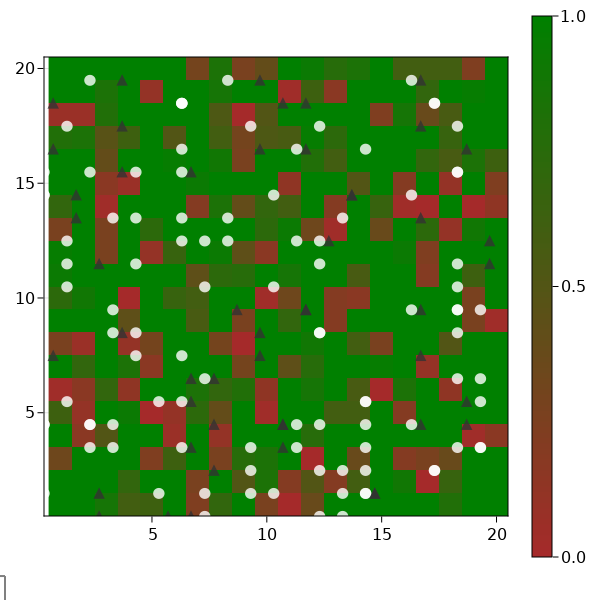

In [16]:
heatkwargs = (colormap = [:brown, :green], colorrange = (0, 1))

plotkwargs = (
    ac = acolor,
    as = 15,
    am = ashape,
    offset = offset,
    heatarray = grasscolor,
    heatkwargs = heatkwargs,
)

fig, _ = abm_plot(model; plotkwargs...)
fig

In [17]:
sheep(a) = a.type == :sheep
wolves(a) = a.type == :wolf
count_grass(model) = count(model.fully_grown)

count_grass (generic function with 1 method)

In [18]:
model = initialize_model()
n = 500
adata = [(sheep, count), (wolves, count)]
mdata = [count_grass]
adf, mdf = run!(model, sheepwolf_step!, grass_step!, n; adata, mdata)

(501×3 DataFrame
 Row │ step   count_sheep  count_wolves 
     │ Int64  Int64        Int64        
─────┼──────────────────────────────────
   1 │     0          100            50
   2 │     1           88            55
   3 │     2           76            58
   4 │     3           70            58
   5 │     4           64            63
   6 │     5           54            64
   7 │     6           43            63
   8 │     7           32            65
   9 │     8           27            69
  10 │     9           25            72
  11 │    10           20            75
  ⋮  │   ⋮         ⋮            ⋮
 492 │   491            0             0
 493 │   492            0             0
 494 │   493            0             0
 495 │   494            0             0
 496 │   495            0             0
 497 │   496            0             0
 498 │   497            0             0
 499 │   498            0             0
 500 │   499            0             0
 501 │   500            0 

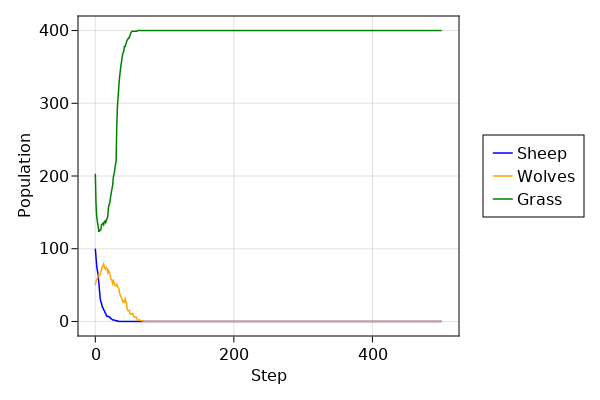

In [19]:
function plot_population_timeseries(adf, mdf)
    figure = Figure(resolution = (600, 400))
    ax = figure[1, 1] = Axis(figure; xlabel = "Step", ylabel = "Population")
    sheepl = lines!(ax, adf.step, adf.count_sheep, color = :blue)
    wolfl = lines!(ax, adf.step, adf.count_wolves, color = :orange)
    grassl = lines!(ax, mdf.step, mdf.count_grass, color = :green)
    figure[1, 2] = Legend(figure, [sheepl, wolfl, grassl], ["Sheep", "Wolves", "Grass"])
    figure
end

plot_population_timeseries(adf, mdf)

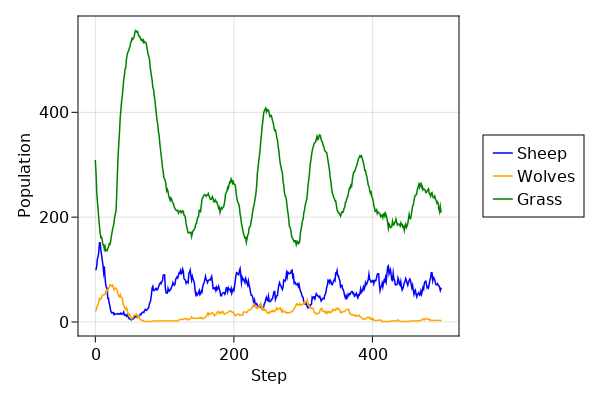

In [20]:
model = initialize_model(
    n_wolves = 20,
    dims = (25, 25),
    Δenergy_sheep = 5,
    sheep_reproduce = 0.2,
    wolf_reproduce = 0.08,
    seed = 7758,
)
adf, mdf = run!(model, sheepwolf_step!, grass_step!, n; adata, mdata)

plot_population_timeseries(adf, mdf)

## Zombie Outbreak

In [21]:
using OpenStreetMapXPlot
using Plots
gr()

Plots.GRBackend()

In [22]:
@agent Zombie OSMAgent begin
    infected::Bool
end

In [23]:
mutable struct Zombie <: AbstractAgent
    id::Int
    pos::Tuple{Int,Int,Float64}
    route::Vector{Int}
    destination::Tuple{Int,Int,Float64}
    infected::Bool
end

In [24]:
function initialise(; map_path = OSM.TEST_MAP)
    model = ABM(Zombie, OpenStreetMapSpace(map_path))

    for id in 1:100
        start = random_position(model) # At an intersection
        finish = OSM.random_road_position(model) # Somewhere on a road
        route = OSM.plan_route(start, finish, model)
        human = Zombie(id, start, route, finish, false)
        add_agent_pos!(human, model)
    end
    # We'll add patient zero at a specific (latitude, longitude)
    start = OSM.road((39.52320181536525, -119.78917553184259), model)
    finish = OSM.intersection((39.510773, -119.75916700000002), model)
    route = OSM.plan_route(start, finish, model)
    # This function call creates & adds an agent, see `add_agent!`
    zombie = add_agent!(start, model, route, finish, true)
    return model
end

initialise (generic function with 1 method)

In [25]:
function agent_step!(agent, model)
    # Each agent will progress 25 meters along their route
    move_along_route!(agent, model, 25)

    if is_stationary(agent, model) && rand(model.rng) < 0.1
        # When stationary, give the agent a 10% chance of going somewhere else
        OSM.random_route!(agent, model)
        # Start on new route
        move_along_route!(agent, model, 25)
    end

    if agent.infected
        # Agents will be infected if they get within 50 meters of a zombie.
        map(i -> model[i].infected = true, nearby_ids(agent, model, 50))
    end
end

agent_step! (generic function with 1 method)

In [26]:
ac(agent) = agent.infected ? :green : :black
as(agent) = agent.infected ? 6 : 5

function plotagents(model)
    ids = model.scheduler(model)
    colors = [ac(model[i]) for i in ids]
    sizes = [as(model[i]) for i in ids]
    markers = :circle
    pos = [OSM.map_coordinates(model[i], model) for i in ids]

    Plots.scatter!(
        pos;
        markercolor = colors,
        markersize = sizes,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
end

plotagents (generic function with 1 method)

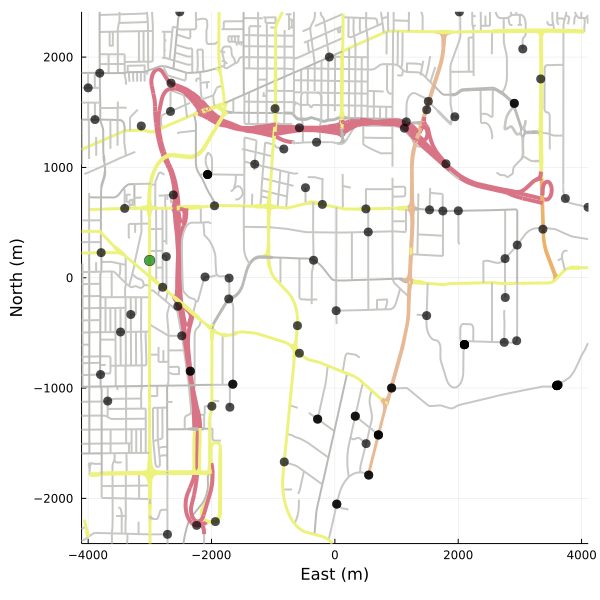

In [27]:
model = initialise()
plotmap(model.space.m)
plotagents(model)

┌ Info: Saved animation to 
│   fn = /home/vlad/SGH/AgentModeling/outbreak.gif
└ @ Plots /home/vlad/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/vlad/SGH/AgentModeling/outbreak.gif")
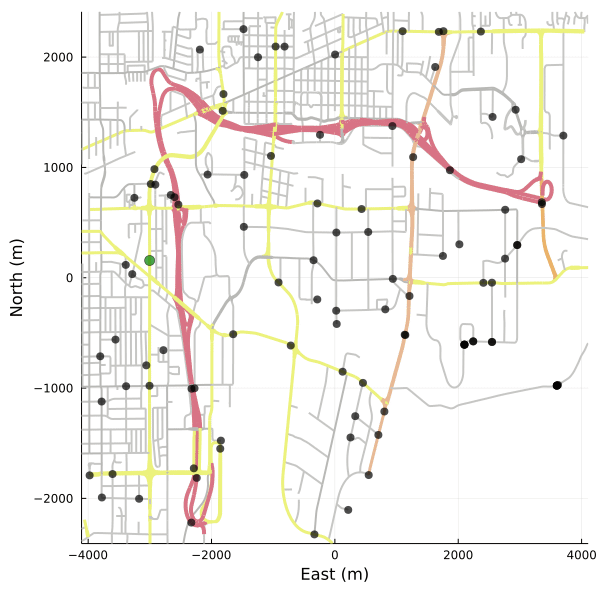

In [28]:
model = initialise()

frames = @animate for i in 0:200
    i > 0 && step!(model, agent_step!, 1)
    plotmap(model.space.m)
    plotagents(model)
end

gif(frames, "outbreak.gif", fps = 15)